##Classificação de Imagens de Documentos

1. Leitura de imagens de disco

```
Keras -> ImageDataGenerator (Data argumentation)
tensorflow -> Leitura de imagem por imagem
np.array  tensor

```



Keras-OCR/ PyTesseract/PyMuPDF
```
PyTesseract
-> extração de caracteres
-> 1 texto por duocumento
```

In [1]:
!pip install -U keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 18.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 37.8 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from keras.layers import Dense,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Leitura de dados

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r '/content/drive/MyDrive/Colab Notebooks/Arquivos/full_3/' 'documents'

Mounted at /content/drive


In [4]:
path_documents = 'documents'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(folder+'/'+img_file)
        dataset_dict['label'].append(folder)


In [5]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])
X = df['filename'].values
y = df['label'].values

In [6]:
lista_subfolders

['scientific _publication', 'email', 'advertisement']

In [7]:
df

,filename,label
0,scientific _publication/2502255678_5684.tif,scientific _publication
1,scientific _publication/10046987_10047002.tif,scientific _publication
2,scientific _publication/2046398702_2046398712.tif,scientific _publication
3,scientific _publication/2505350166.tif,scientific _publication
4,scientific _publication/2505421989.tif,scientific _publication
...,...,...
2956,advertisement/2044905226.tif,advertisement
2957,advertisement/2058504145.tif,advertisement
2958,advertisement/91383464.tif,advertisement
2959,advertisement/6132.tif,advertisement


Criação dos logits dos labels




```
Labels Nominais "Categoricos" -> Atributos Inteiros Ordinais -> to_categorial -> Logits
```



In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

In [9]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

lista_train = []
for i in range(0,len(X_train)):
    lista_train.append([X_train[i],y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
    lista_valid.append([X_valid[i],y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
    lista_test.append([X_test[i],y_test[i]])

df_train = pd.DataFrame(lista_train,columns = ['filename','label'])
df_valid = pd.DataFrame(lista_valid,columns = ['filename','label'])
df_test = pd.DataFrame(lista_test,columns = ['filename','label'])

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   rotation_range=20,
                                    width_shift_range=0.2,  
                                    height_shift_range=0.2,   
                                    horizontal_flip=True)

agnostic_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = agnostic_datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

test_generator = agnostic_datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                             class_mode='categorical',
                                             shuffle=True)

test_generator.image_shape

Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


(256, 256, 3)

Hyperparameters

In [11]:
dims = (224,224,3)
num_classes = 3

model = Sequential()
# Parte 1 da AlexNet
model.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model.add(Conv2D(96,(11,11), strides=(4,4)))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

# Parte 2 da AlexNet
model.add(Conv2D(256,(5,5), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

# Parte 3 da AlexNet
model.add(Conv2D(384,(3,3), strides=(1,1),padding="same",activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(384,(3,3), strides=(1,1),padding="same",activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(256,(3,3), strides=(1,1),padding="same",activation='relu'))
model.add(Dropout(0.4))

model.add(MaxPooling2D((3, 3),strides=(2,2)))

model.add(Flatten())

model.add(Dense(4096))
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(4096))
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       6

In [13]:
sgd = SGD(lr=0.00001)

model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

model.fit(train_generator,
          epochs=10,
          batch_size=16,
          validation_data=valid_generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
65/65 [==============================] - 48s 546ms/step - loss: 1.7150 - accuracy: 0.3156 - val_loss: 1.0969 - val_accuracy: 0.3211
Epoch 2/10
65/65 [==============================] - 36s 547ms/step - loss: 1.5623 - accuracy: 0.3547 - val_loss: 1.0971 - val_accuracy: 0.2930
Epoch 3/10
65/65 [==============================] - 35s 538ms/step - loss: 1.4751 - accuracy: 0.3668 - val_loss: 1.0938 - val_accuracy: 0.4451
Epoch 4/10
65/65 [==============================] - 36s 548ms/step - loss: 1.4283 - accuracy: 0.3769 - val_loss: 1.0849 - val_accuracy: 0.4704
Epoch 5/10
65/65 [==============================] - 35s 532ms/step - loss: 1.3894 - accuracy: 0.3924 - val_loss: 1.0669 - val_accuracy: 0.5070
Epoch 6/10
65/65 [==============================] - 35s 539ms/step - loss: 1.3104 - accuracy: 0.4199 - val_loss: 1.0375 - val_accuracy: 0.5352
Epoch 7/10
65/65 [==============================] - 35s 538ms/step - loss: 1.3274 - accuracy: 0.4011 - val_loss: 0.9949 - val_accuracy: 0.7831

```
-> Treinamento requer muitas iterações -> overfitting

+treinamento -validação -teste

```

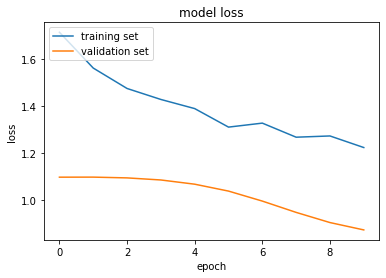

In [14]:
history_fine = model.history
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [15]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [16]:
y_prob

array([[0.55460215, 0.11986007, 0.32553777],
       [0.6180444 , 0.1590537 , 0.22290194],
       [0.4805896 , 0.18768813, 0.33172226],
       ...,
       [0.31727138, 0.32205212, 0.3606765 ],
       [0.29151508, 0.41133285, 0.297152  ],
       [0.31163332, 0.3173271 , 0.37103957]], dtype=float32)

In [17]:
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 1,
       2, 0, 1, 0, 2, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0,
       0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 1,
       0, 2, 1, 0, 2, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 2, 0, 0, 0, 2, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0,
       0, 1, 0, 2, 2, 1, 1, 0, 0, 2, 0, 0, 1, 0, 1, 2, 1, 0, 0, 2, 0, 1,
       0, 0, 2, 2, 0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 0, 0, 2, 1, 2, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 1, 0, 1, 1, 2,
       2, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2, 1, 0,
       1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2,
       1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 2, 2, 0, 1,
       2, 0, 0, 1, 0, 1, 0, 2, 2, 1, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2,
       0, 1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 2, 2, 0, 1,

In [18]:
y_test = test_generator.classes

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.33      0.44      0.38       180
           1       0.30      0.26      0.28       170
           2       0.34      0.27      0.30       184

    accuracy                           0.33       534
   macro avg       0.32      0.33      0.32       534
weighted avg       0.33      0.33      0.32       534



Transferência de Aprendizado

Grande quantidade de dados s/ risco de overfitting

In [20]:
model_resnet_pt = Sequential()

pre_trained_model = ResNet50(input_shape = (224,224,3), include_top = False, weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False
    

model_resnet_pt.add(pre_trained_model)
model_resnet_pt.add(Flatten())

model_resnet_pt.add(Dense(num_classes))
#model_resnet_pt.add(Activation())



94781440/94765736 [==============================] - 0s 0us/step
